# Example: State Space Models of the Excess Return Distribution
Fill me in

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable. The dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [13]:
Δt = (1.0/252.0);
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;
risk_free_rate = 0.045;

## Specify a ticker of interest
Fill me in

In [15]:
all_firms_growth_matrix = log_return_matrix(dataset, list_of_all_firms, Δt = Δt, 
    risk_free_rate = risk_free_rate);

In [16]:
ticker_of_interest = "AMD";
excess_growth_rate_array = findfirst(x->x==ticker_of_interest,list_of_all_firms) |> i -> all_firms_growth_matrix[:,i];

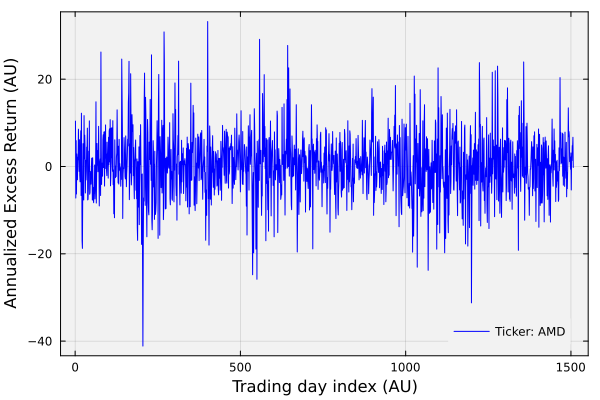

In [17]:
plot(excess_growth_rate_array, label="Ticker: $(ticker_of_interest)", c=:blue, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
xlabel!("Trading day index (AU)", fontsize=18)
ylabel!("Annualized Excess Return (AU)", fontsize=18)

## Build the HiPPO-LegS model instance
Fill me in.

In [19]:
tspan = (start = 0.0, stop = 3, step = 1/252)
L = range(tspan.start, stop=tspan.stop, step = tspan.step) |> collect |> length
signal = excess_growth_rate_array[1:L];

In [20]:
number_of_hidden_states = 750;
model = build(MySisoLegSHippoModel, (
    number_of_hidden_states = number_of_hidden_states,
    Δt = Δt,
    uₒ = signal[1],
    C = 2*randn(number_of_hidden_states)
));

Fill me in

In [22]:
(T1,X1,Y1) = solve(model, tspan, signal);

`Unhide` the code block below to see how we plotted the untrained growth rate versus the observed growth rate for the ticker specided in the `ticker_of_interest` variable.

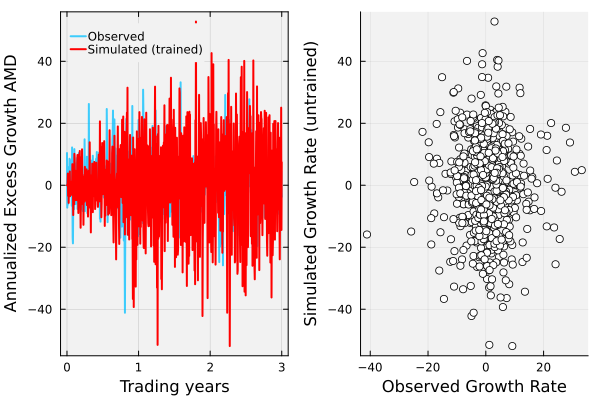

In [24]:
let
    # layout -
    l = @layout [a b]

    # time series -
    p1 = plot(T1,signal, label="Observed", lw=2, c=:deepskyblue, alpha=0.75, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(p1, T1,Y1,label="Simulated (trained)", lw=2, c=:red, xlabel="Trading years", ylabel="Annualized Excess Growth $(ticker_of_interest)", fontsize=18)
    
    # sim v obs
    p2 = scatter(signal, Y1, label="", xlabel="Observed Growth Rate", ylabel="Simulated Growth Rate (untrained)", c=:white, msc=:black)

    # build the plot -
    plot(p1,p2,layout=l)
end

### HiPPO model training
Fill me in.

In [26]:
model_updated = deepcopy(model);
model_updated.Ĉ = load(joinpath(_PATH_TO_DATA,"HiPPO-SPY-N750.jld2"))["model"].Ĉ;

Fill me in

In [28]:
(T2,X2,Y2) = solve(model_updated, tspan, signal);

`Unhide` the code block below to see how we plotted the `trained` annualized excess growth rate versus the observed growth rate for the ticker specified in the `ticker_of_interest` variable.

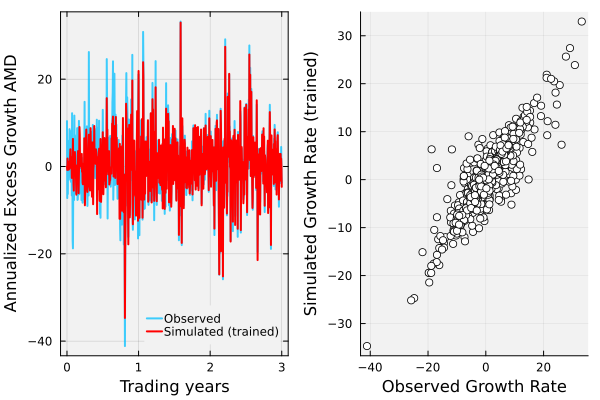

In [30]:
let

    # layout -
    l = @layout [a b]

    # time series -
    p1 = plot(T2,signal, label="Observed", lw=2, c=:deepskyblue, alpha=0.75, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(p1, T2,Y2,label="Simulated (trained)", lw=2, c=:red, xlabel="Trading years", ylabel="Annualized Excess Growth $(ticker_of_interest)", fontsize=18)
    
    # sim v obs
    p2 = scatter(signal, Y2, label="", xlabel="Observed Growth Rate", ylabel="Simulated Growth Rate (trained)", c=:white, msc=:black)

    # build the plot -
    plot(p1,p2,layout=l)
end

## Visualize the Return Distributions
Fill me in

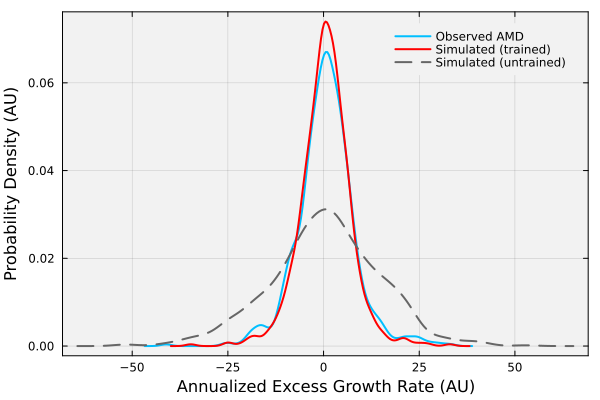

In [100]:
density(signal, label="Observed $(ticker_of_interest)", bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent, lw=2, c=:deepskyblue)
density!(Y2, normalize=true, c=:red, label="Simulated (trained)", lw=2)
density!(Y1, normalize=true, c=:gray40, label="Simulated (untrained)", lw=2, ls=:dash)
xlabel!("Annualized Excess Growth Rate (AU)", fontsize=18)
ylabel!("Probability Density (AU)", fontsize=18)

Fill me in

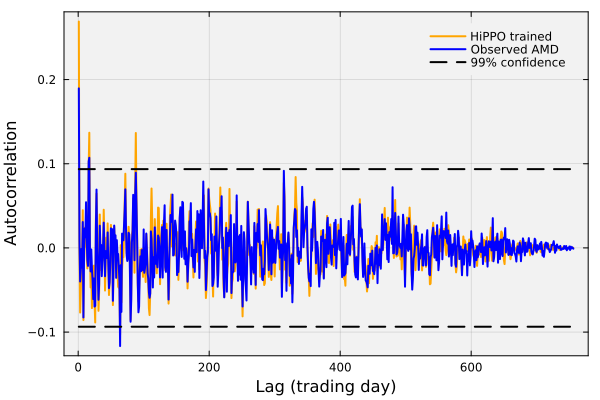

In [34]:
number_of_steps = length(Y2);
plot(autocor(Y2, (1:(number_of_steps - 1) |> collect)), label="HiPPO trained", lw=2, c=:orange, 
    bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
plot!(autocor(signal, (1:(number_of_steps-1)) |> collect), label="Observed $(ticker_of_interest)", lw=2, c=:blue)
LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
xlabel!("Lag (trading day)", fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

## Can the HiPPO model predict a return series?
Fill me in

In [36]:
d = fit_mle(Laplace, signal);
new_signal_vector = Array{Float64,1}();
for i ∈ 0:5*(252)
    r = rand(d);
    push!(new_signal_vector, r);
end

In [37]:
tspan = (start = 0.0, stop = 1.0, step = 1/252);
L = 100; # buffer
(T3,X3,Y3) = prediction(model_updated, tspan, new_signal_vector, L = L);

Fill me in

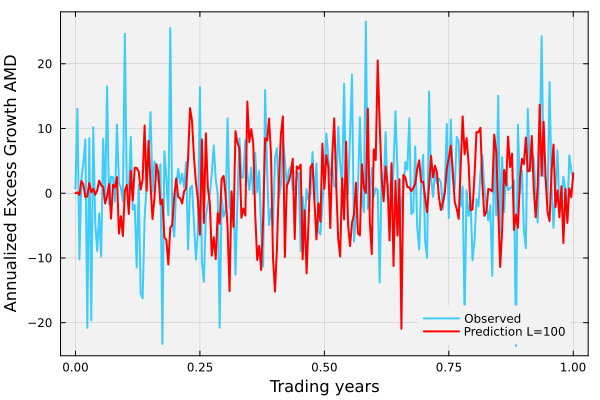

In [39]:
let

    # layout -
    N = length(T3);

    # time series -
    p1 = plot(T3,new_signal_vector[1:N], label="Observed", lw=2, c=:deepskyblue, alpha=0.75, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    plot!(p1, T3,Y3,label="Prediction L=$(L)", lw=2, c=:red, xlabel="Trading years", ylabel="Annualized Excess Growth $(ticker_of_interest)", fontsize=18)
end

Fill me in

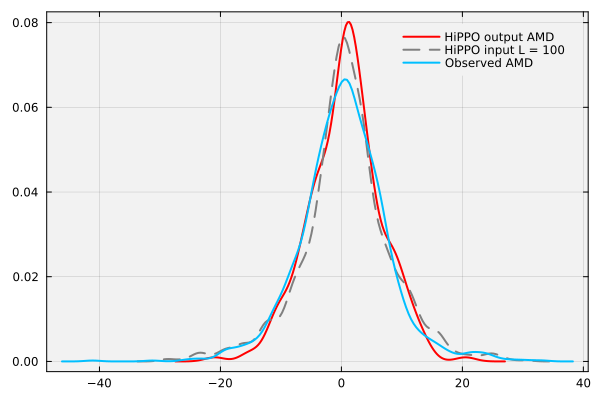

In [89]:
density(Y3, label="HiPPO output $(ticker_of_interest)", lw=2, c=:red, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
density!(new_signal_vector,c=:gray, label="HiPPO input L = $(L)", lw=2, ls=:dash)
density!(excess_growth_rate_array, c=:deepskyblue, label="Observed $(ticker_of_interest)", lw=2)

Fill me in

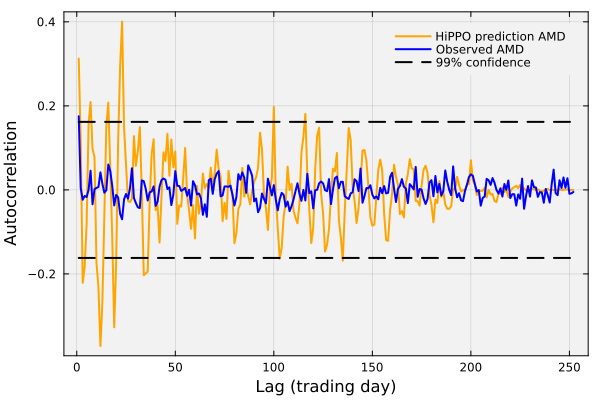

In [41]:
plot(autocor(Y3, (1:(number_of_steps-1) |> collect)), label="HiPPO prediction $(ticker_of_interest)", lw=2, c=:orange, 
    bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
plot!(autocor(excess_growth_rate_array, (1:(number_of_steps-1)) |> collect), label="Observed $(ticker_of_interest)", lw=2, c=:blue)
LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
xlabel!("Lag (trading day)", fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.